In [52]:
%load_ext autoreload
%autoreload 2

import gc
import os
import mne
import joblib
import matplotlib
import numpy as np
import global_settings as gs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from copy import copy
from relevance import utils as rel_utils
from training import utils as train_utils
from relevance.results import Results
import matplotlib.gridspec as gridspec

# --------------------------------------------

layer_num_filter_dict = {
    "b1_conv1": 8, 
    "b1_conv2": 16,  
    "b2_conv1": 16, 
    "b2_conv2": 16, 
    "b3_flatten": 192, 
}

index_to_layer_dict = {
    1: "b1_conv1", # temporal: frequency filters
    2: "b1_conv2", # spatial filters
    3: "b2_conv1", # temporal summary
    4: "b2_conv2", # optimal mix 
    5: "b3_flatten", # dense  
}

# --------------------------------------------

# This index determines which layer is analyzed in this notebook
# If you want to look at other layers than the last, you first have to compute the relevances using main_relevance.py
LAYER_INDEX = 4

# If true, the results are overwritten if they already exist
overwrite_if_exists = False

LAYER = index_to_layer_dict[LAYER_INDEX]
NUM_FILTER = layer_num_filter_dict[LAYER]

# Specifying that we want to use the first iteration of the repeated executions of the cross validation
CV_INDEX = 0

bands = [(1,4,"delta"), (4,8,"theta"), (8,12,"alpha"), (12,30,"beta"), (30,60,"gamma"), (0, 60, "all")] 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


------------------------------
## Preparation

In [53]:
def create_results_name(dh_name):
    return os.path.join(gs.base_path, f"results_{dh_name}_{gs.use_what_for_similarity}_{gs.num_samples_to_select}")

compute_new_for_ds = []
results_for_ds = []

for dh in gs.data_handlers:
    compute_new_for_ds.append(False)
    results_for_ds.append(None)

for dh_idx, dh in enumerate(gs.data_handlers):

    if overwrite_if_exists:
        compute_new_for_ds[dh_idx] = True
    else:
        try:
            results = joblib.load(create_results_name(dh.ds_name))
            results_for_ds[dh_idx] = results
        except:
            compute_new_for_ds[dh_idx] = True

### Prepare Results objects

In [54]:
# prepare Results-Object

for dh_idx, dh in enumerate(gs.data_handlers):

    results = results_for_ds[dh_idx]

    if compute_new_for_ds[dh_idx]:
        results = Results(gs.base_path, gs.CV_params, dh.num_subjects, dh.sampling_rate, gs.class_labels, LAYER, NUM_FILTER,  
                        gs.select_samples_by_class, gs.use_which_data, gs.num_samples_to_select, dh.ds_name, 
                        gs.reversed_classes, gs.select_correct, dh.channel_names, gs.use_what_for_similarity, False)
        
        results_for_ds[dh_idx] = results

### Create UMAP embeddings

In [55]:
# create embeddings per combination of (class x CV) (across folds)

for dh_idx, dh in enumerate(gs.data_handlers):

    plot = True

    if compute_new_for_ds[dh_idx]:

        results = results_for_ds[dh_idx]

        for label in gs.class_labels:
            for cv_idx in range(results.num_CVs):

                X_sim = results.get_data_class_cv("X_sim", label, cv_idx)

                embedding = rel_utils.compute_embedding(X_sim, results.layer)
                
                results.set_data_class_cv(embedding, "embedding", label, cv_idx)
                    
        results_for_ds[dh_idx] = results

### Perform clustering

In [56]:

for dh_idx, dh in enumerate(gs.data_handlers):
    print("Dataset:", dh.ds_name)

    if compute_new_for_ds[dh_idx]:

        results = results_for_ds[dh_idx]
        
        for class_label in gs.class_labels:
            print("CLASS LABEL", class_label)

            if "GME" in dh.ds_name:
                
                if LAYER_INDEX == 5:
                    eps = 0.25
                    min_samples = 15
                else:
                    eps = 0.5
                    min_samples = 10

            elif "KUL" in dh.ds_name:
                eps = 0.5
                min_samples = 15
            else: # MI
                eps = 0.4
                min_samples = 15

            for cv_idx in range(results.num_CVs):

                embedding = results.get_data_class_cv("embedding", class_label, cv_idx)

                cluster_indices, cluster_labels, unique_labels, cluster_indices_original, unique_labels_original = \
                        rel_utils.cluster_embedding(embedding, eps, min_samples, title="", plot=False)

                results.set_data_class_cv(cluster_indices, "indices", class_label, cv_idx)
                results.set_data_class_cv(cluster_labels, "labels", class_label, cv_idx)
                results.set_data_class_cv(unique_labels, "unique_labels", class_label, cv_idx)

                results.set_data_class_cv(cluster_indices_original, "indices_plotting", class_label, cv_idx)
                results.set_data_class_cv(unique_labels_original, "unique_labels_plotting", class_label, cv_idx)

        results_for_ds[dh_idx] = results

Dataset: GME


### Compute Correlations between models

In [57]:
compute_correlations = True

if compute_correlations:

    for dh_idx, dh in enumerate(gs.data_handlers):
        results = results_for_ds[dh_idx]
        results.compute_correlations(gs.CV_params, calc_correlations_new=overwrite_if_exists, discard_negative=False, use_relevance=True, use_X=True, plot=False)
        joblib.dump(results, create_results_name(dh.ds_name))

----------------

## Results

In [66]:

class_label_map = {}

for dh in gs.data_handlers:
    class_label_map[dh.ds_name] = {}

class_label_map["CHO"] = {
    0: "left",
    1: "right",
}

class_label_map["KUL"] = {
    0: "left",
    1: "right",
}

class_label_map["GME"] = {
    0: "int.",
    1: "ext.",
}

class_label_map_long = {}

for dh in gs.data_handlers:
    class_label_map_long[dh.ds_name] = {}

class_label_map_long["CHO"] = {
    0: "Left Hand",
    1: "Right Hand",
}

class_label_map_long["KUL"] = {
    0: "Left Ear",
    1: "Right Ear",
}

class_label_map_long["GME"] = {
    0: "Internal",
    1: "External",
}

dataset_name_map = {
    "CHO": "MI",
    "KUL": "AA",
    "GME": "IEA",
}

cluster_colors = cm.get_cmap('Set2').colors

set2_cmap = cm.get_cmap('Set2')
corr_colors = set2_cmap.colors

cluster_color_map = {}
cluster_color_map["NC"] = (0.8,0.8,0.8)
cluster_color_map["all"] = (0.8,0.8,0.8)

for idx, col in enumerate(cluster_colors):
    cluster_color_map[str(idx+1)] = col

### Plot Clusters

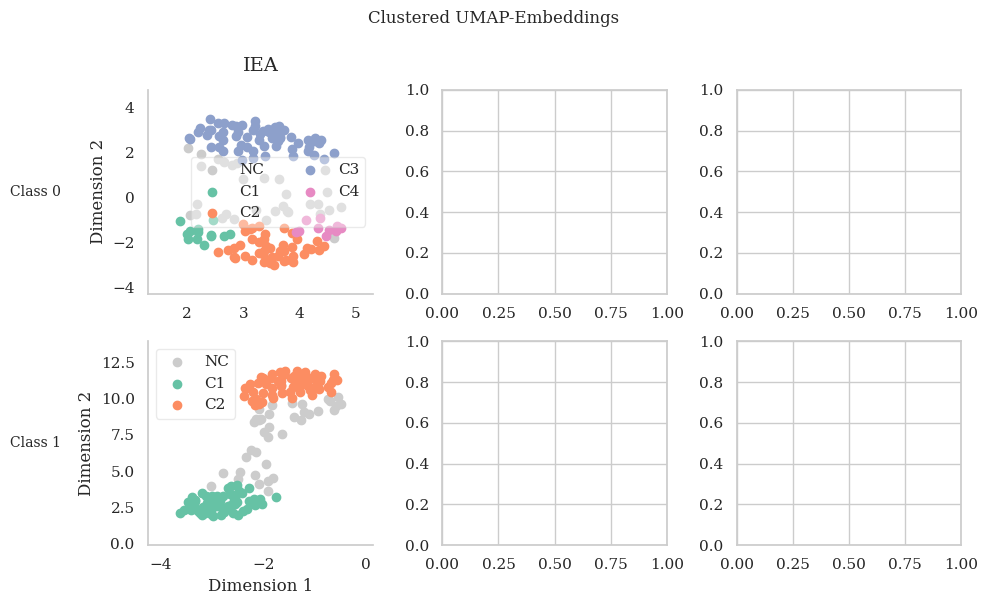

In [67]:
plot_clusters = True

fig, axes = plt.subplots(2, 3, figsize=(10, 6))

if plot_clusters:
        
    for idx, (results, dh) in enumerate(zip(results_for_ds, gs.data_handlers)):

        axes_ = []
        for row_idx, row in enumerate(axes):
            axes_.append(axes[row_idx][idx])

        cv_idx = 0

        class_label = 0
        embedding_c0 = results.get_data_class_cv("embedding", class_label, cv_idx)
        ci_orig_c0 = results.get_data_class_cv("indices_plotting", class_label, cv_idx)
        ul_orig_c0 = results.get_data_class_cv("unique_labels_plotting", class_label, cv_idx)

        class_label = 1
        embedding_c1 = results.get_data_class_cv("embedding", class_label, cv_idx)
        ci_orig_c1 = results.get_data_class_cv("indices_plotting", class_label, cv_idx)
        ul_orig_c1 = results.get_data_class_cv("unique_labels_plotting", class_label, cv_idx)

        rel_utils.plot_clusters(embedding_c0, embedding_c1, ci_orig_c0, ci_orig_c1, ul_orig_c0, ul_orig_c1, title="",
                                class_label_map=class_label_map[dh.ds_name], cluster_color_map=cluster_color_map, ax=axes_)


        axes_[0].set_title(dataset_name_map[dh.ds_name], fontsize=14, y=1.05)
        axes_[1].set_title("")  

        axes_[0].set_xlabel("")

        if idx > 0:
            axes_[0].set_ylabel("")
            axes_[1].set_ylabel("")
        else:
            axes_[0].text(-0.5, 0.5, "Class 0", transform=axes_[0].transAxes, va='center', ha='center', rotation=0)
            axes_[1].text(-0.5, 0.5, "Class 1", transform=axes_[1].transAxes, va='center', ha='center', rotation=0)

        axes_[0].set_xlabel("")

plt.suptitle("Clustered UMAP-Embeddings", y=1.0)
plt.tight_layout()
plt.show()

### Plot Clusters (all datasets)

--------------------------------------------------
Dataset: GME


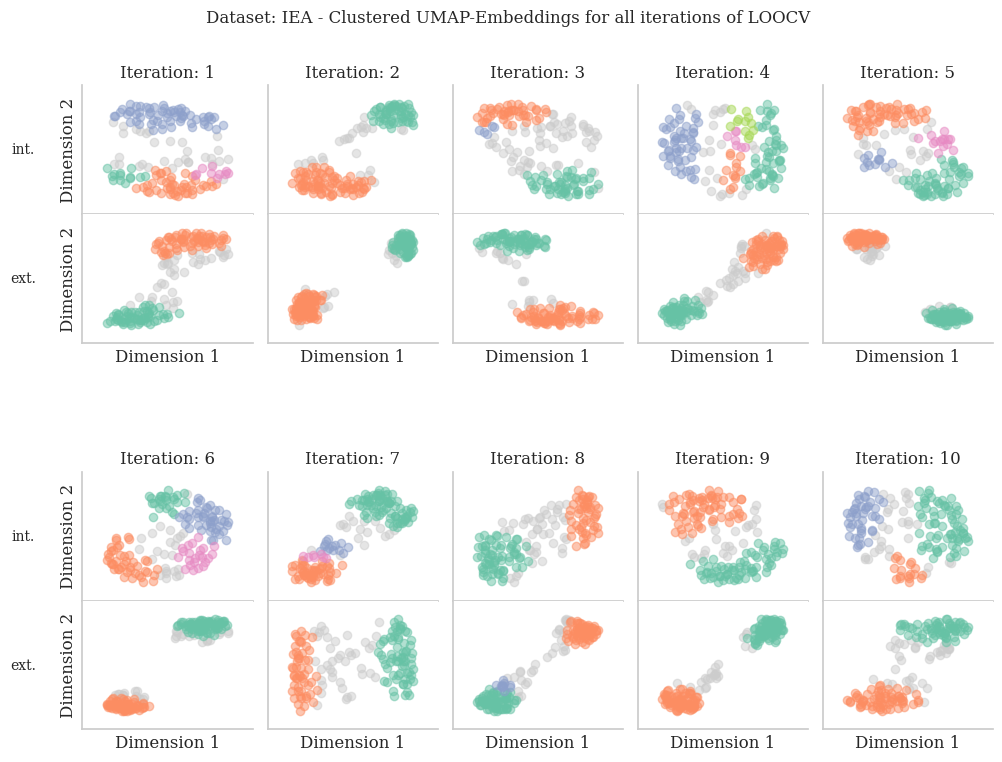

In [68]:
plot_clusters_all = True

if plot_clusters_all:
        
    for results, dh in zip(results_for_ds, gs.data_handlers):

        print("-"*50)
        print("Dataset:", dh.ds_name)

        cols = results.num_CVs//2

        rows = 5
        width = 10
        height = 7.5

        fig, axes = plt.subplots(nrows=rows, ncols=cols, gridspec_kw={"height_ratios" : [1,1,1,1,1], "hspace":0}, figsize=(width, height))

        for row in range(0, rows): 

            for col in range(0, cols):

                plot_line = row == 2
                cv_idx = col

                if row > 2: 
                    cv_idx += cols


                class_label = row
                if row > 2:
                    class_label -= 3

                ax = axes[row][col]

                if not plot_line:

                    embedding = results.get_data_class_cv("embedding", class_label, cv_idx)
                    cluster_indices = results.get_data_class_cv("indices_plotting", class_label, cv_idx)
                    unique_labels = results.get_data_class_cv("unique_labels_plotting", class_label, cv_idx)

                    show_xlabel = class_label == 1 
                    show_ylabel = col == 0

                    if class_label == 0:
                        title = f"Iteration: {cv_idx+1}"
                    else:
                        title = ""

                    rel_utils.plot_cluster_subplot(embedding, cluster_indices, unique_labels, class_label, title=title, class_label_map=class_label_map[dh.ds_name], ax=ax, 
                                                    show_xlabel=show_xlabel, show_ylabel=show_ylabel, cluster_color_map=cluster_color_map)

                    # Hide x and y ticks
                    ax.set_xticks([]) 
                    ax.set_yticks([])  

                    if col == 0:
                        label = f"{class_label_map[dh.ds_name][class_label]}"

                        ax.text(-0.35, 0.5, label, transform=ax.transAxes, va='center', ha='center', rotation=0)
                else:
                    ax.set_visible(False)

        plt.suptitle(f"Dataset: {dataset_name_map[dh.ds_name]} - Clustered UMAP-Embeddings for all iterations of LOOCV", y=1.01)
        plt.tight_layout()

### Plot cluster metrics

all ['all']
all ['all']


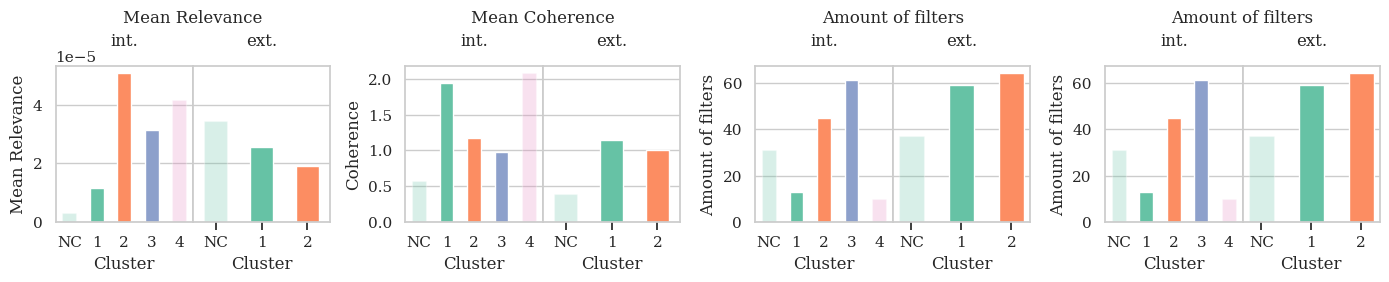

In [69]:
plot_metrics = True

if plot_metrics:

    color_options = ["blue", "green", "teal", "purple"]

    for results, dh in zip(results_for_ds, gs.data_handlers):

        color_lists = []

        for class_label in [0,1]:
                
            cidx_keys = copy(results.get_data_class_cv("unique_labels", class_label, cv_idx))

            colors = []

            count = 0
            alpha = 1.0

            fraction = 0.25

            for k in cidx_keys:

                if k == "NC":
                    colors.append((cluster_colors[count], alpha*fraction))
                elif k == "all":
                    colors.append((cluster_colors[count], alpha*fraction))
                else:
                    colors.append((cluster_colors[count], alpha))
                    count += 1
            color_lists.append(colors)

        # ---------------------------------------------------
            
        rows = 1
        cols = 4

        cv_idx = CV_INDEX
        # exclude = ["noise", "all"]
        exclude = ['all']

        fig = plt.figure(figsize=(14, 3))

        grid = plt.GridSpec(rows, cols)

        for i in range(cols):

            if i == 0:
                title = "Mean Relevance"
            elif i==1:
                title = "Mean Coherence"
            # elif i==2:
            #     title = "Precision Score"
            else:
                title = "Amount of filters"
            
            # create fake subplot just to title pair of subplots
            fake = fig.add_subplot(grid[i])
            
            fake.set_title(f'{title}\n', fontweight='normal', size=12, y=1.1)
            fake.set_axis_off()

            gs = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[i], wspace=0)

            # -------------------------------------------------

            subplot_title_height = 0.95

            ax = fig.add_subplot(gs[0])
            
            ax.set_title(f'{class_label_map[dh.ds_name][0]}\n', y=subplot_title_height)

            if i==0:
                results.plot_cluster_relevance_subplot(0, cv_idx, exclude_cluster=exclude, ax=ax, colors=color_lists[0])
            elif i==1:
                results.plot_cluster_coherence_subplot(0, cv_idx, exclude_cluster=exclude, ax=ax, colors=color_lists[0])
            else:
                results.plot_cluster_relevance_subplot(0, cv_idx, exclude_cluster=exclude, ax=ax, colors=color_lists[0])

                results.plot_cluster_amount_of_filter_subplot(0, cv_idx, ax, exclude_cluster=exclude, colors=color_lists[0])

            ax.xaxis.grid(False)
            
            # -------------------------------------------------

            ax = fig.add_subplot(gs[1], sharey=ax)
            ax.set_title(f'{class_label_map[dh.ds_name][1]}\n', y=subplot_title_height)
            
            # hide ticks and labels
            ax.tick_params(left=False, labelleft=False, labelbottom=True, bottom=True)

            if i==0:
                results.plot_cluster_relevance_subplot(1, cv_idx, exclude_cluster=exclude, ax=ax, colors=color_lists[1])
            elif i==1:
                results.plot_cluster_coherence_subplot(1, cv_idx, exclude_cluster=exclude, ax=ax, colors=color_lists[1])
            else:
                results.plot_cluster_amount_of_filter_subplot(1, cv_idx, ax, exclude_cluster=exclude, colors=color_lists[1])

            # ax.grid(True)
            ax.set_ylabel("")
            ax.xaxis.grid(False)

            # -------------------------------------------------

        fig.patch.set_facecolor('white')
        # fig.suptitle('SUPERTITLE', fontweight='bold', size=16)

        fig.tight_layout()

### Plot cluster metrics (all datasets)

3
all ['all']
all ['all']


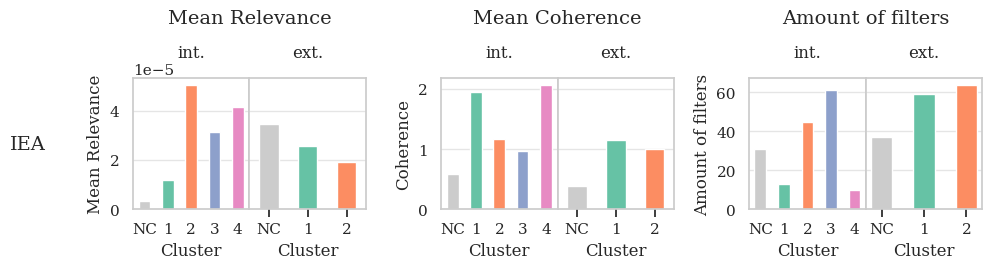

In [70]:
import global_settings as gs

plot_metrics = True

if plot_metrics:

    cv_idx = CV_INDEX

    rows = len(results_for_ds)  
    cols = 3

    fig = plt.figure(figsize=(10, 3 * rows))
    grid = plt.GridSpec(rows, cols)
    
    for idx, (results, dh) in enumerate(zip(results_for_ds, gs.data_handlers)):

        color_lists = []
        
        for class_label in [0,1]:
            cidx_keys = copy(results.get_data_class_cv("unique_labels", class_label, cv_idx))
            colors = []
            count = 0
            alpha = 1
            fraction = 1

            for k in cidx_keys:

                if k == "all":
                    continue

                color = cluster_color_map[k]

                if k == "NC" or k == "all":
                    colors.append((color, alpha*fraction))
                else:
                    colors.append((color, alpha))
                    count += 1
            color_lists.append(colors)

        # ---------------------------------------------------
            
        exclude = ["all"]  # ["NC", "all"]
     
        for i in range(cols):

            # Calculate the index for the current subplot within the grid
            grid_idx = grid[idx, i]
            
            # create fake subplot just to title pair of subplots
            fake = fig.add_subplot(grid_idx)

            if i == 0:
                title = "Mean Relevance"
            elif i==1:
                title = "Mean Coherence"
            else:
                title = "Amount of filters"
                        
            if idx == 0:
                fake.set_title(f'{title}\n', fontweight='normal', size=14, y=1.2)
            fake.set_axis_off()
    
            gridspec_ = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid_idx, wspace=0)


            show_xlabel = idx == len(gs.data_handlers)-1

            # -------------------------------------------------

            subplot_title_height = 0.95

            ax = fig.add_subplot(gridspec_[0])
            
            ax.set_title(f'{class_label_map[dh.ds_name][0]}\n', y=subplot_title_height)

            if i==0:
                results.plot_cluster_relevance_subplot(0, cv_idx, exclude_cluster=exclude, ax=ax, colors=color_lists[0], show_xlabel=show_xlabel)
            elif i==1:
                pass
                results.plot_cluster_coherence_subplot(0, cv_idx, exclude_cluster=exclude, ax=ax, colors=color_lists[0], show_xlabel=show_xlabel)
            else:
                results.plot_cluster_amount_of_filter_subplot(0, cv_idx, ax, exclude_cluster=exclude, colors=color_lists[0], show_xlabel=show_xlabel)
                pass

            # ax.grid(False)
            ax.xaxis.grid(False)
            ax.yaxis.grid(True, alpha=0.5)

            # -------------------------------------------------

            ax = fig.add_subplot(gridspec_[1], sharey=ax)
            ax.set_title(f'{class_label_map[dh.ds_name][1]}\n', y=subplot_title_height)
            
            # hide ticks and labels
            ax.tick_params(left=False, labelleft=False, labelbottom=True, bottom=True)

            if i==0:
                print(len(colors))
                results.plot_cluster_relevance_subplot(1, cv_idx, exclude_cluster=exclude, ax=ax, colors=color_lists[1], show_xlabel=show_xlabel)
            elif i==1:
                pass
                results.plot_cluster_coherence_subplot(1, cv_idx, exclude_cluster=exclude, ax=ax, colors=color_lists[1], show_xlabel=show_xlabel)
            else:
                pass
                results.plot_cluster_amount_of_filter_subplot(1, cv_idx, ax, exclude_cluster=exclude, colors=color_lists[1], show_xlabel=show_xlabel)

            # ax.grid(False, axis="y")
            # ax.grid(False)
            ax.xaxis.grid(False)
            ax.yaxis.grid(True, alpha=0.5)

            ax.set_ylabel("")

            # -------------------------------------------------        

            if i == 0:
                label = dataset_name_map[dh.ds_name]
                ax.text(-1.9, 0.5, label, transform=ax.transAxes, va='center', ha='center', rotation=0, weight='normal', fontsize=14)

            # -------------------------------------------------        

        fig.patch.set_facecolor('white')
        # fig.suptitle('SUPERTITLE', fontweight='bold', size=16)

        fig.tight_layout()

### Plot filter distribution

--------------------------------------------------
Dataset: GME


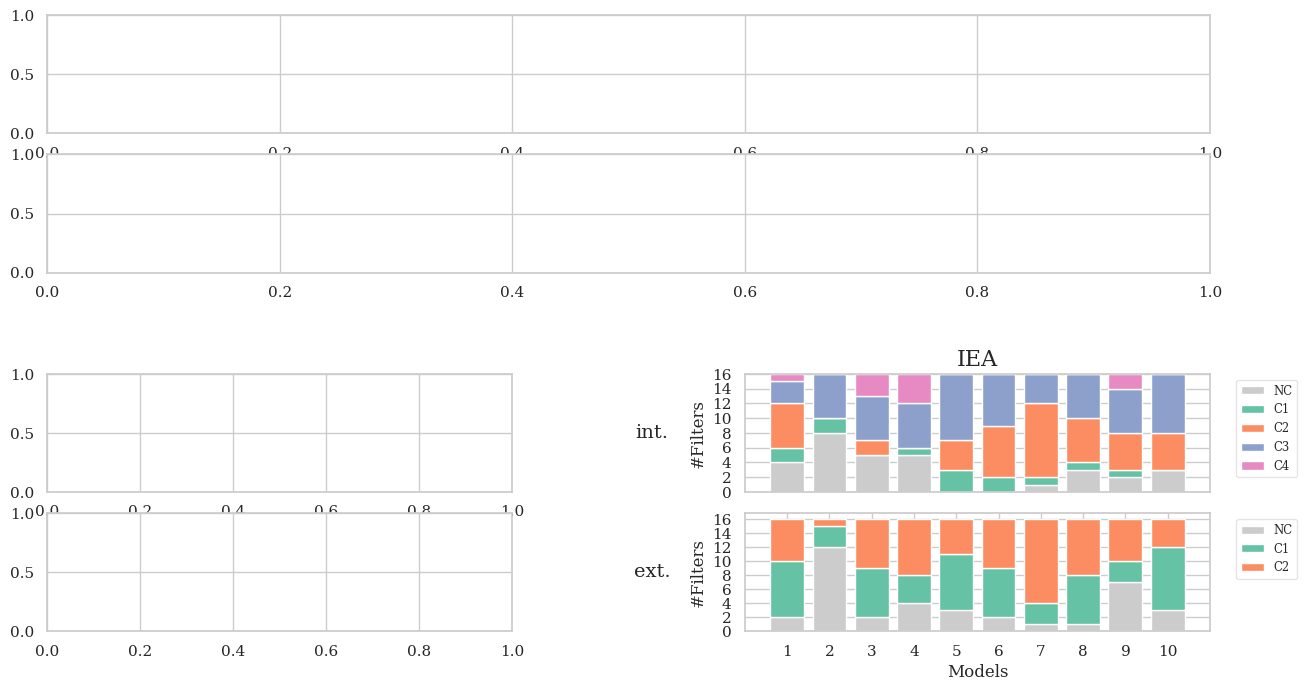

In [71]:
plot_cluster_distribution = True

cv_idx = CV_INDEX

if plot_cluster_distribution:

    fig = plt.figure(figsize=(15, 8))

    h = 3.5
    gs_ = gridspec.GridSpec(5, 2, height_ratios=[h,h,h/2,h,h])

    # Create subplots
    ax1 = plt.subplot(gs_[0, :])  # Single subplot in the first row
    ax2 = plt.subplot(gs_[1, :])  # Single subplot in the second first row

    ax_ = plt.subplot(gs_[2, :])  # empty row 

    ax3 = plt.subplot(gs_[3, 0])  # First subplot in the third row
    ax4 = plt.subplot(gs_[4, 0])  # First subplot in the fourth row

    ax5 = plt.subplot(gs_[3, 1])  # Second subplot in the third row
    ax6 = plt.subplot(gs_[4, 1])  # Second subplot in the fourth row

    ax_.set_visible(False)

    # Layout
    # -- ax1 --
    # -- ax2 --
    # ax_ empty space
    # ax3 - ax5
    # ax4 - ax6

    # --------------------------------------------------------

    ds_axis_map = {}

    for dh in gs.data_handlers:
        ds_axis_map[dh.ds_name] = {}

    try:
        ds_axis_map["CHO"][0] = ax1
        ds_axis_map["CHO"][1] = ax2
    except:
        pass

    try:
        ds_axis_map["KUL"][0] = ax3
        ds_axis_map["KUL"][1] = ax4
    except:
        pass

    try:
        ds_axis_map["GME"][0] = ax5
        ds_axis_map["GME"][1] = ax6
    except:
        pass
    
    # --------------------------------------------------------

    for results, dh in zip(results_for_ds, gs.data_handlers):

        print("-"*50)
        print("Dataset:", dh.ds_name)

        exclude = ['all']

        if dh.ds_name == "CHO":
            width = 14
            row_title_offset = -0.09
            legend_offset = 1.08
        elif dh.ds_name == "KUL":
            width = 6
            row_title_offset = -0.2
            legend_offset = 1.2
        else:
            width = 6
            row_title_offset = -0.2
            legend_offset = 1.2

        for class_label in [0,1]:

            # ax = axes[class_label]

            ax = ds_axis_map[dh.ds_name][class_label]

            if class_label == 0:
                show_xticks = False
            else:
                show_xticks = True

            results.plot_cluster_distribution_stacked_subplot(class_label, cv_idx, ax, cluster_color_map=cluster_color_map, exclude_cluster=exclude,
                                                              show_xticks=show_xticks)
            
            class_label_str = class_label_map[dh.ds_name][class_label]

            handles, labels = ax.get_legend_handles_labels()
            num_entries = 1 # len(labels)

            ax.text(row_title_offset, 0.5, class_label_str, transform=ax.transAxes, va='center', ha='center', rotation=0, weight='normal', fontsize=14)

            legend = ax.legend(loc='upper right', fontsize='smaller', ncol=num_entries, bbox_to_anchor=(legend_offset, 1))
            legend.get_frame().set_alpha(0.5)  # Set the transparency of the legend background

            if class_label != 1:
                ax.set_title(dataset_name_map[dh.ds_name], fontweight="normal", fontsize=16)

    plt.subplots_adjust(wspace=0.5) 


### Plot topographic maps

----------------------------------------------------------------------------------------------------
GME
0
--------------------------------------------------
NC


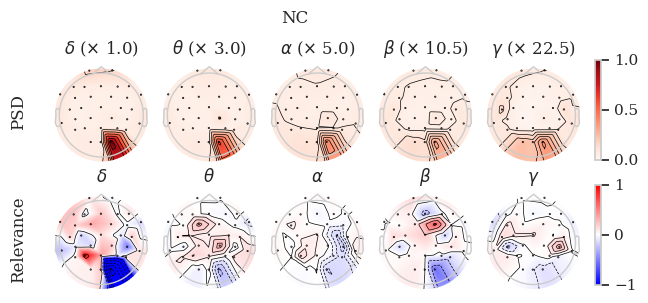

1


<Figure size 640x480 with 0 Axes>

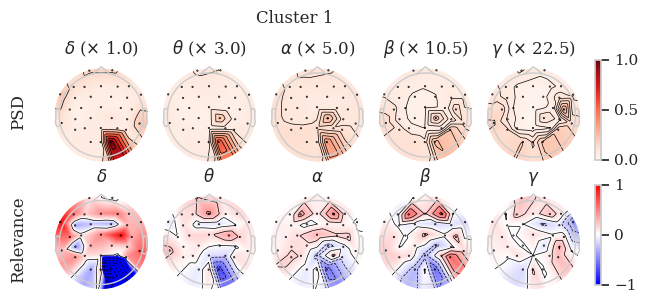

2


<Figure size 640x480 with 0 Axes>

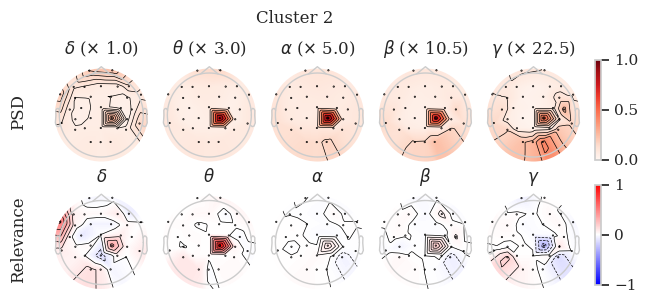

3


<Figure size 640x480 with 0 Axes>

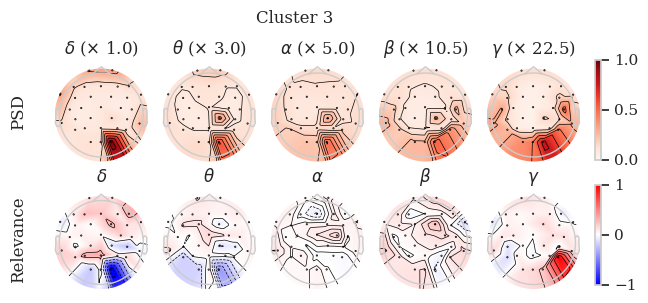

4


<Figure size 640x480 with 0 Axes>

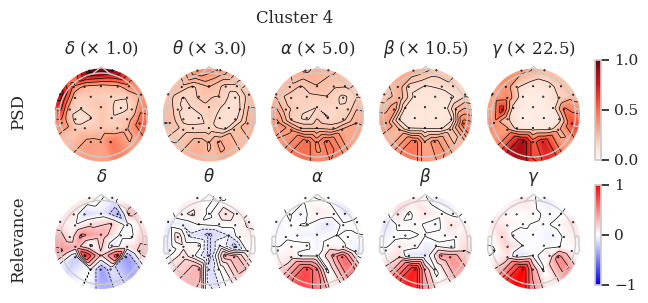

all


<Figure size 640x480 with 0 Axes>

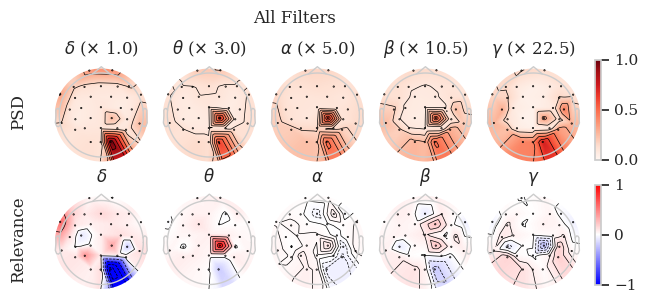

1
--------------------------------------------------
NC


<Figure size 640x480 with 0 Axes>

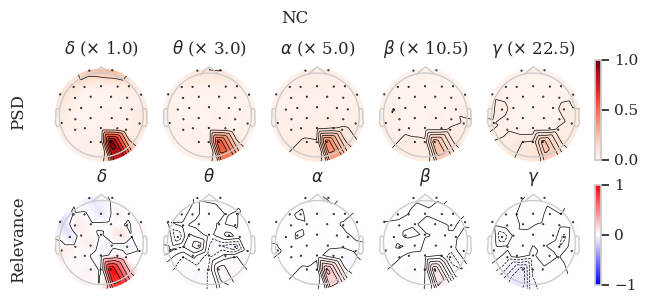

1


<Figure size 640x480 with 0 Axes>

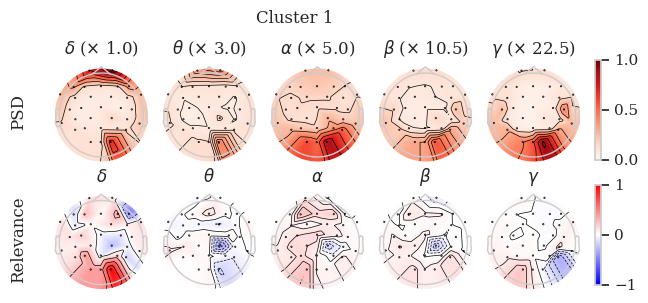

2


<Figure size 640x480 with 0 Axes>

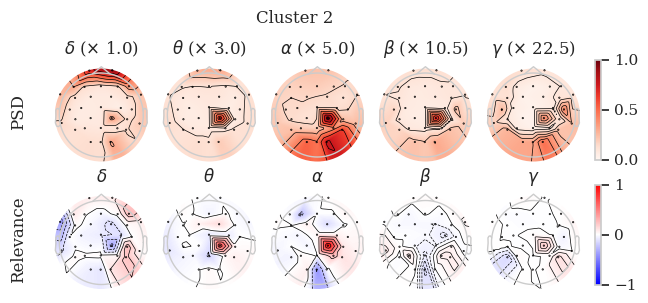

all


<Figure size 640x480 with 0 Axes>

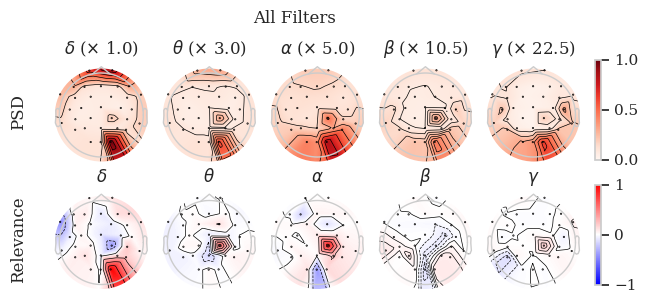

<Figure size 640x480 with 0 Axes>

In [83]:
plot_topographies = True

if plot_topographies:

    for results, dh in zip(results_for_ds, gs.data_handlers):

        print("-"*100)
        print(dh.ds_name)

        exclude = [] # 'all']

        for class_label in gs.class_labels:

            print(class_label)

            if class_label == 0:
                title = "Left Hand"
            else:
                title = "Right Hand"
            
            title = None

            for cv_idx, cv in enumerate(gs.CV_params):

                if cv_idx != CV_INDEX:
                    continue

                print("-"*50)

                results.plot_cluster_signal(class_label=class_label, cv_idx=cv_idx, 
                                            title=title, exclude_cluster=exclude, sig_log_scale=False, 
                                            sig_global_scale=True, rel_global_scale=True, psd=True,  sig_scale_bands=True, rel_scale_bands=False, sig_norm=True, rel_norm=True, 
                                            cluster_order=None, rel_common_scale=False, sig_common_scale=True, sig_mean=True, rel_mean=False, rel_vlim=(-1,1), sig_vlim=(0, 1), 
                                            negative_lim=True, rel_cmap="bwr", remove_neg=False, scale_per_band=False, scale_1_div_f=True, plot_ideal_topo=False)

### Plot results of ICA Pipeline

alpha alpha
>> GME
      Cluster: 1


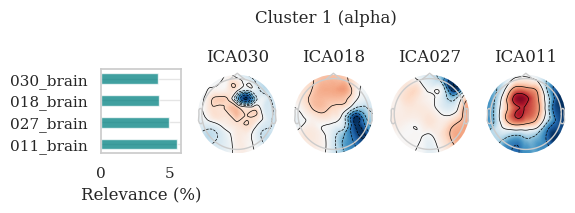

      Cluster: 2


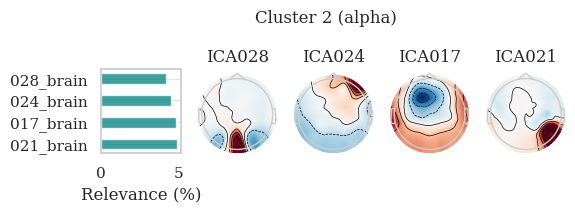

      Cluster: 3


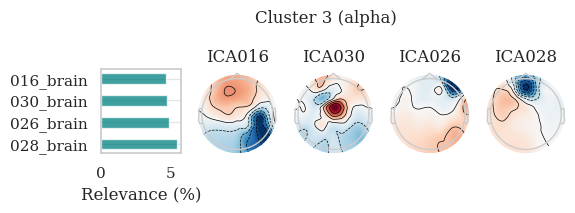

      Cluster: 4


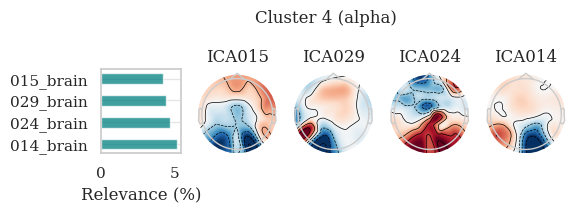

      Cluster: 1


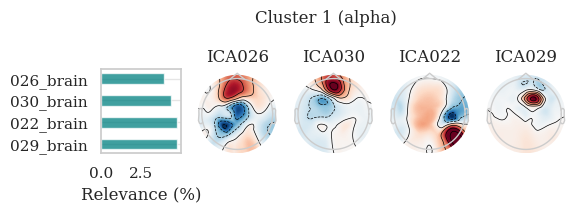

      Cluster: 2


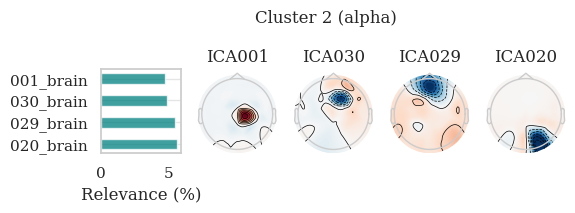

In [72]:
plot_ica = True

cv_idx = CV_INDEX

alpha = "alpha"

print("alpha", alpha)

if plot_ica: 
        
    for results, dh in zip(results_for_ds, gs.data_handlers):

        if dh.ds_name != "GME":
            continue

        print(">>", dh.ds_name)
        exclude = ['all', 'NC']

        for class_label in gs.class_labels:
            # print("  Class Label", class_label_map_long[dh.ds_name][class_label])

            title = "" # class_label_map_long[dh.ds_name][class_label]
            results.plot_ica(class_label, cv_idx, exclude_cluster=exclude, figsize=(6,1), title=title, time=True, band=alpha, ica_title_fontsize=8)

In [73]:
from matplotlib.colors import LinearSegmentedColormap

colors = []

cmap = matplotlib.colormaps['tab20'].resampled(20)

for i in range(0, 20):
    colors.append(cmap(i))

cmap = colors

### Plot functional grouping

GME


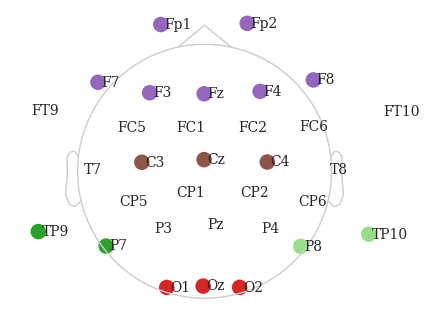

In [74]:
bands = [(0,4,"delta"), (4,8,"theta"), (8,12,"alpha"), (12,30,"beta"), (30,60,"gamma")]
brain_regions = []

# ------------------------------------------------------------------------

left_motor = ("Left Motor", ["FC5", "FC3", "FC1", "C5", "C3", "C1", "CP5", "CP3", "CP1"], cmap[0])
right_motor = ("Right Motor", ["FC2", "FC4", "FC6", "C2", "C4", "C6", "CP2", "CP4", "CP6"], cmap[1])
motor = ("Motor", left_motor[1] + right_motor[1] + ["FCz", "Cz", "CPz"], cmap[0])
brain_regions += [left_motor, right_motor, motor]

# ------------------------------------------------------------------------

left_temporal = ("Left Temporal", ["FT7", "T7", "TP7", "T9", "FT9", "TP9"], cmap[2])
right_temporal = ("Right Temporal", ["FT8", "T8", "TP8", "T10", "FT10", "TP10"], cmap[3])
temporal = ("Temporal", left_temporal[1] + right_temporal[1], cmap[2])
brain_regions += [left_temporal, right_temporal, temporal]
        
# ------------------------------------------------------------------------

left_parietal = ("Left Parietal", ["TP7", "P7", "PO7", "P9", "P5", "TP9"], cmap[4])
right_parietal = ("Right Parietal", ["TP8", "P8", "PO8", "P10", "P6", "TP10"], cmap[5])
parietal = ("Parietal", left_parietal[1] + right_parietal[1], cmap[4])
brain_regions += [left_parietal, right_parietal, parietal]

# ------------------------------------------------------------------------

left_occipital = ("Left Occipital", ["PO7", "O1", "PO3"], cmap[6])
right_occipital = ("Right Occipital", ["PO8", "O2", "PO4"], cmap[7])
occipital = ("Occipital", ["POz", "Oz"] + left_occipital[1] + right_occipital[1], cmap[6])
brain_regions += [left_occipital, right_occipital, occipital]

# ------------------------------------------------------------------------

left_frontal = ("Left Frontal", ["Fp1", "AF3", "AF7", "F7", "F5", "F3", "F1"], cmap[8])
right_frontal = ("Right Frontal", ["Fp2", "AF4", "AF8", "F8", "F6", "F4", "F2"], cmap[9])
frontal = ("Frontal", ["Fpz", "AFz", "Fz"] + left_frontal[1] + right_frontal[1], cmap[8])
brain_regions += [left_frontal, right_frontal, frontal]

# ------------------------------------------------------------------------

left_central = ("Left Central", ["C5", "C3", "C1"], cmap[10])
right_central = ("Right Central", ["C2", "C4", "C6"], cmap[11])
central = ("Central", ["Cz"] + left_central[1] + right_central[1], cmap[10])
    
# -------------------------------------------------------------------------------
    

channels = [
    "Fp1", "Fpz", "Fp2", "F7", "F3", "Fz", "F4", "F8", "FC5", "FC1", "FC2", "FC6", 
    "T7", "C3", "Cz", "C4", "T8", "CP5", "CP1", "CP2", "CP6", "P7", "P3", "Pz", 
    "P4", "P8", "PO9", "O1", "Oz", "O2", "PO10", "TP9", "TP7", "TP8", "TP10", "P9", 
    "P10", "AFF1", "AFz", "AFF2", "F9", "F10", "FFCC5h", "FFCz", "FFCC6h", "FFC1", 
    "FFC2", "FFT7h", "FFT8h", "FFC9h", "FFC10h", "FTT7h", "FTT8h", "FTT9h", "FTT10h", 
    "CCP5h", "CCP3h", "CCP1h", "CCP2h", "CCP4h", "CCP6h", "FCC3h", "FCC4h", "AFF5h", 
    "AFF6h"
]

all = ("All", channels, cmap[10])

# -------------------------------------------------------------------------------

settings_per_dataset = {}

for dh in gs.data_handlers:
    settings_per_dataset[dh.ds_name] = {}
    settings_per_dataset[dh.ds_name]["brain_regions"] = []
    settings_per_dataset[dh.ds_name][0] = {}
    settings_per_dataset[dh.ds_name][1] = {}
    settings_per_dataset[dh.ds_name][0]["cluster"] = []
    settings_per_dataset[dh.ds_name][1]["cluster"] = []


try:
    settings_per_dataset["CHO"]["brain_regions"] = [left_frontal, right_frontal, left_motor, right_motor, left_parietal, right_parietal]
    settings_per_dataset["CHO"][0]["cluster"] = "all"
    settings_per_dataset["CHO"][1]["cluster"] = "all"
except:
    pass

try:
    settings_per_dataset["KUL"]["brain_regions"] = [left_frontal, right_frontal, left_temporal, right_temporal, left_occipital, right_occipital]
    settings_per_dataset["KUL"][0]["cluster"] = "all"
    settings_per_dataset["KUL"][1]["cluster"] = "all"
except:
    pass

try:
    settings_per_dataset["GME"]["brain_regions"] = [frontal, occipital, left_parietal, right_parietal, central]
    settings_per_dataset["GME"][0]["cluster"] = "all"
    settings_per_dataset["GME"][1]["cluster"] = "all"
except:
    pass

# ----------------------------------------------------------------------

plot_sensors_of_brain_regions = True

if plot_sensors_of_brain_regions: 

    for results, dh in zip(results_for_ds, gs.data_handlers):
        print(dh.ds_name)

        brain_regions = settings_per_dataset[dh.ds_name]["brain_regions"]
        results.plot_sensors_of_brain_regions(brain_regions, cmap=cmap, figsize=(5,5))

>> 0
>> 1


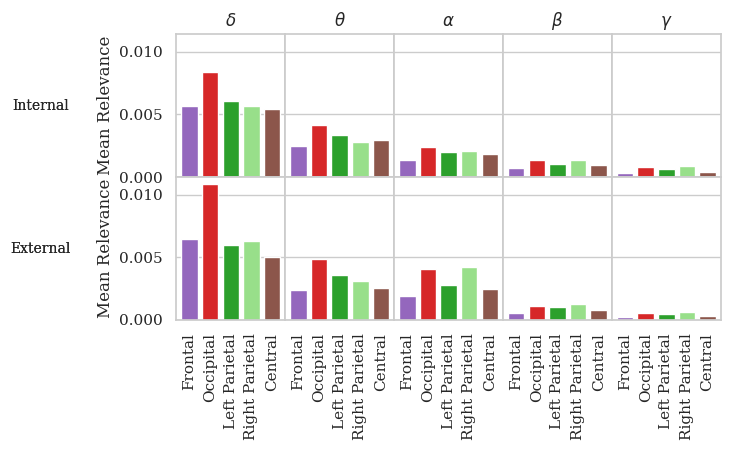

In [75]:
plot_cluster_functional_grouping = True

cv_idx = CV_INDEX
    
if plot_cluster_functional_grouping:

    for results, dh in zip(results_for_ds, gs.data_handlers):

        if dh.ds_name != "GME":
            continue

        brain_regions = settings_per_dataset[dh.ds_name]["brain_regions"]
                
        num_bands = len(bands)

        width = len(brain_regions)*1.5

        _, axes = plt.subplots(2, num_bands, figsize=(width, 4.75), sharey=True,  gridspec_kw = {'wspace':0, 'hspace':0})
        
        for class_label in [0,1]:
            print(">>", class_label)
                
            cluster_idx = settings_per_dataset[dh.ds_name][class_label]["cluster"]
            
            if dh.ds_name == "CHO": 
                ds_name = "Motor Imagery"
                x_offset = -1.25
            elif dh.ds_name == "KUL": 
                ds_name = "Auditory Attention"
                x_offset = -1
            else: 
                ds_name = "Internal/External Attention"
                x_offset = -1.25

            title = ""

            rels = results.plot_cluster_functional_grouping(class_label, cv_idx, brain_regions=brain_regions, 
                                                    bands=bands, cluster_idx=cluster_idx, 
                                                    title=title, only_positive=True, abs=False,
                                                    axes=axes[class_label], aggregation="mean",
                                                    from_ideal_topo=False, use_X=False)
            try:
                if class_label == 1:
                    for ax in axes[1]:
                        ax.set_title("")
                else:
                    for ax in axes[0]:
                        ax.set_xticklabels([])
            except:
                pass
            try:
                axes[0][0].text(x_offset, 0.5, class_label_map_long[dh.ds_name][0], transform=axes[0][0].transAxes, va='center', ha='center', rotation=0)
                axes[1][0].text(x_offset, -0.5, class_label_map_long[dh.ds_name][1], transform=axes[0][0].transAxes, va='center', ha='center', rotation=0)
            except:
                pass
            
        plt.suptitle(f"{title}")
        plt.tight_layout()
        plt.show()

In [76]:
labels = []

all_data = []

for band in rels:

    for region_data, brain_region in zip(rels[band], brain_regions):

        label = f"{brain_region[0]} {band}"
        labels.append(label)
        signal = np.array(region_data)
        signal = np.mean(signal, axis=2)
        signal = np.mean(signal, axis=1)
        all_data.append(signal)

data = np.array(all_data)

### Plot model concept correlations

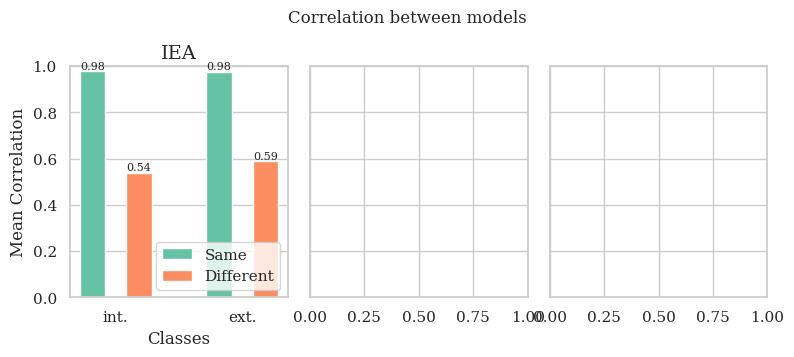

In [ ]:
plot_correlation_barchart = True

colors = corr_colors


if plot_correlation_barchart:

    for use_relevance in [False]:

        fig, axes = plt.subplots(1,3, figsize=(9, 3), sharey="row")

        for idx, (results, dh) in enumerate(zip(results_for_ds, gs.data_handlers)):

            xticks = [class_label_map[dh.ds_name][0], class_label_map[dh.ds_name][1]]

            ax = axes[idx]

            ax.grid(False)

            ax.set_title(dataset_name_map[dh.ds_name], fontsize=14)
            results.plot_correlation_barchart(ax=ax, xticks=xticks, colors=colors, use_relevance=use_relevance)

            ax.yaxis.grid(True)

            if idx > 0:
                ax.set_ylabel("")
            
        # plt.grid(False)
        plt.subplots_adjust(wspace=0.1)

        if use_relevance:
            title_str = "Correlation between models - Relevance"
        else:
            title_str = "Correlation between models"

        plt.suptitle(title_str, y=1.07)
        # plt.grid(axis='x')

        plt.show()

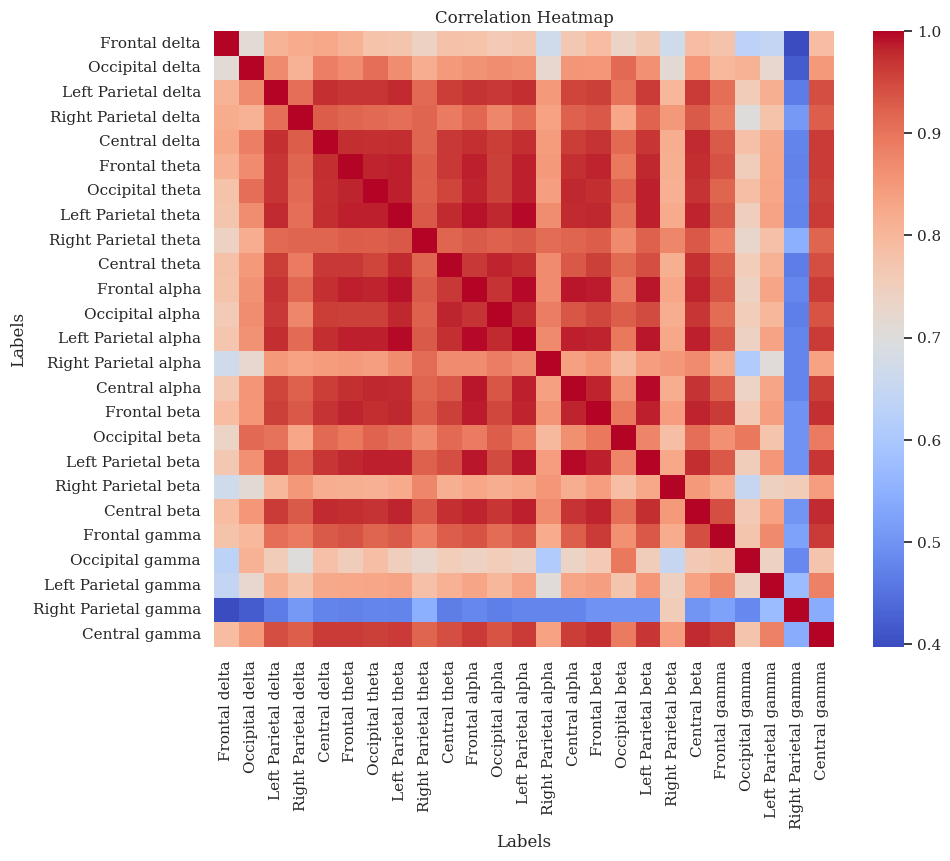

In [77]:
import seaborn as sns

def compute_correlations(data, labels):
    # Compute correlations
    correlations = np.corrcoef(data)
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlations, annot=False, cmap='coolwarm', fmt=".2f", xticklabels=labels, yticklabels=labels) 
    plt.title('Correlation Heatmap')
    plt.xlabel('Labels')
    plt.ylabel('Labels')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

compute_correlations(data, labels)

----------------------------
## Additional Analyses

These may be broken

### Cluster class label distribution

In [78]:

plot_cluster_class_label_distribution = False

if plot_cluster_class_label_distribution:

    for results, dh in zip(results_for_ds, gs.data_handlers):

        exclude = ['all', 'noise']

        for class_label in gs.class_labels:

            if class_label == 0:
                title = "External"
            else:
                title = "Internal"

            for cv_idx, cv in enumerate(gs.CV_params):

                print("-"*50)
                exclude = ["noise", "all"]

                results.plot_cluster_class_label_distribution(class_label, cv_idx, title="", normalize=True, exclude_cluster=[])

### Frequency Filter

In [ ]:
plot_frequency_filtering_of_layers = False

if plot_frequency_filtering_of_layers:

    def analyse_frequency_filtering_of_layer(cv_idx, fold_idx, CV_params):

        info = mne.create_info(ch_names=dh.channel_names, sfreq=128, ch_types='eeg')

        X_time, y, _ = rel_utils.get_data(dh, None, False, 'both', CV_params[0], False, use_which_data="test", subj=fold_idx, composite=gs.composite)

        y = np.array(y)
        # X_time = torch.from_numpy(X_time).type(torch.cuda.FloatTensor)
        
        fig, ax = plt.subplots(figsize=(3, 2)) 
        ax.set_title("PSD Baseline")

        raw = mne.io.RawArray(X_time.cpu().detach().numpy().reshape(X_time.shape[1], -1), info)
        raw.plot_psd(fmax=60, n_fft=2048, show=True, average=True, color="orange", ax=ax)
        ax.set_title("Whole Dataset - Baseline")

        plt.show()

        print("_"*20)

        params = CV_params[cv_idx]

        model = train_utils.load_model(dh, params, X_time.shape[-2], X_time.shape[-1], fold_idx, return_dict=False)
        model.eval()

        # def load_model(dh, params, num_chn, num_data_points, subject=None, return_dict=False, show_errors=True, 
        #           use_min_val_loss=False, epochs=None, num_conv_layers=None):

        # activation_maps = None
        
        def hook(module, input, output):
            global activation_maps
            activation_maps = output

        hook_handle = model.b1_conv1.register_forward_hook(hook)  
        model(X_time)
        hook_handle.remove()

        global activation_maps

        activation_maps = activation_maps.cpu().detach().numpy()
        activation_maps = np.transpose(activation_maps, [1, 0, 2, 3])

        num_filter = activation_maps.shape[0]
        fig, axes = plt.subplots(2, num_filter//2, figsize=(2*num_filter, 6), sharey=True) 

        for filter in range(num_filter):

            row = int(filter // (num_filter//2))
            col = int(filter - row*(num_filter//2))

            # ax = axes[filter]
            ax = axes[row][col]
            eeg_data = activation_maps[filter]
            eeg_data = eeg_data.reshape(eeg_data.shape[1], -1)
            
            raw = mne.io.RawArray(eeg_data, info)
            raw.plot_psd(fmax=60, n_fft=2048, show=False, average=True, color="orange", ax=ax)  

            ax.set_title(f"Filter {filter+1}")

        plt.subplots_adjust(wspace=0)
        plt.suptitle(f"Layer: Conv 1")
        plt.show()


    for results, dh in zip(results_for_ds, gs.data_handlers):

        analyse_frequency_filtering_of_layer(cv_idx=5, fold_idx=5, CV_params=gs.CV_params)


### Plot relevance per subject (Histogram)

In [ ]:
import global_settings as gs_

plot_relevance_per_subject = True

if plot_relevance_per_subject:

    for results, dh in zip(results_for_ds, gs.data_handlers):


        if dh.ds_name != "GME":
            continue
            
        for cv_nr, params in enumerate(gs.CV_params):

            subjects = [i for i in range(dh.num_subjects)]

            rel_per_subject_c0 = []
            rel_per_subject_c1 = []

            for subj in subjects:

                for class_label in [0,1]:

                    title = f"{class_label}_subjects_{subj}" 

                    if subj == "all":
                        model_id_of_subj = 0
                    else:
                        model_id_of_subj = subj

                    X, R = rel_utils.load_data_and_compute_relevance(
                            dh, params, class_label, title="", 
                            proportion_of_samples=1.0,  
                            discard_negative_rel=True, 
                            reversed_classes=False, 
                            model_id_of_subj=model_id_of_subj, 
                            subject=subj, 
                            use_which_data="test",
                            select_correct=None, 
                            select_samples_by_class=True, 
                            composite=gs_.composite, 
                            freq_domain=False)

                    R = R.cpu().detach().numpy()

                    if class_label == 0:
                        rel_per_subject_c0.append(np.sum(R))
                    else:
                        rel_per_subject_c1.append(np.sum(R))

            width_per_person = 6/10
            width = dh.num_subjects * width_per_person 
            print(width_per_person)
            _, axes = plt.subplots(1,2, figsize=(width,3), sharey="row")

            plt.suptitle(f"Relevance per subject, CV nr. {cv_nr}", y=1.1)

            for idx, ax in enumerate(axes):
                ax.set_title(f"Class {idx}")

                if idx == 0:
                    ax.bar(subjects, rel_per_subject_c0)
                    ax.set_ylabel("Relevance")
                else:
                    ax.bar(subjects, rel_per_subject_c1)

                ax.set_xlabel("Subjects")
                ax.set_xticks(subjects)
            plt.show()

            break

### Plot distribution of selected samples

In [ ]:
plot_distribution_of_selected_samples = False

if plot_distribution_of_selected_samples:

    for results, dh in zip(results_for_ds, gs.data_handlers):

        results.plot_distribution_of_selected_samples()

### Plot pattern of single filters

In [ ]:
plot_single_filter_pattern = False

if plot_single_filter_pattern:

    for results, dh in zip(results_for_ds, gs.data_handlers):

        results.plot_single_filter()

### Plot LRP Baseline

In [ ]:
import global_settings as gs

plot_LRP_baseline = False

if plot_LRP_baseline:
    gc.collect()
    params = gs.CV_params[0]

    proportion_of_samples_list = [1.0, 0.1] # [1.0, 0.1, 0.01] #  [1.0, 0.5, 0.1, 0.01]
    
    for results, dh in zip(results_for_ds, gs.data_handlers):

        if dh.ds_name != "GME":
            continue
        
        subjects = [0,1,2,3,4,5,6,7,8,9,10,11,12] # 0,1] # ,2,3,4,5,6,7,8,9]  

        for subj in subjects:
            for class_label in [1]: # [0,1]:
                for proportion_of_samples in proportion_of_samples_list: 

                    # title = f"{dh.label_to_string_map[class_label]}, subjects: {subj}, proportion: {int(100*proportion_of_samples)}%" 
                    title = f"Class {class_label}, subjects: {subj}, proportion: {int(100*proportion_of_samples)}%" 

                    if subj == "all":
                        model_id_of_subj = 0
                    else:
                        model_id_of_subj = subj

                    X_time, y_time, _ = rel_utils.get_data(dh, None, False, 'both', gs.CV_params[0], False, use_which_data="test", subj=subj, composite=gs.composite)

                    results.plot_LRP_baseline(
                        dh, params, class_label=class_label, title=title, proportion_of_samples=proportion_of_samples, 
                        model_id_of_subj=model_id_of_subj, 
                        
                        subject=subj,
                        use_which_data="test",
                        
                        discard_negative_rel=True, 
                        reversed_classes=False, 
                        select_correct=None, 
                        select_samples_by_class=True,
                        composite=gs.composite,
                    )

### Plot correlation matrices

In [85]:
plot_correlation_matrices = False
colors = corr_colors


if plot_correlation_matrices:

    for over_folds in [False, True]:

        for use_relevance in [True, False]:
                
            for idx, (results, dh) in enumerate(zip(results_for_ds, gs.data_handlers)):

                print("Dataset:", dh.ds_name)

                num_subjects = dh.num_subjects

                if over_folds:
                    cols = 5
                    rows = 2
                else:
                    if dh.ds_name == "CHO":
                        cols = 5
                        rows = 10
                    elif dh.ds_name == "GME":
                        cols = 5
                        rows = 2
                    else:
                        cols = 4
                        rows = 5

                figsize = (cols*3, rows*3)

                # ---------------------------------------------------------------------

                for class_label in [0,1]:

                    print("  class:", class_label)

                    fig, axes = plt.subplots(rows, cols, figsize=figsize)
                    axes = axes.flatten()

                    if len(axes) > dh.num_subjects:
                        
                        for ax in axes[dh.num_subjects-1:]:
                            ax.set_visible(False)

                    if dh.ds_name == "CHO" and over_folds:
                        tick_size = 6
                    else:
                        tick_size = 9
                    
                    heatmaps = matrices = results.plot_correlation_matrices(gs.CV_params, axes=axes, use_relevance=use_relevance,
                                                                            over_folds=over_folds, class_label=class_label, tick_size=tick_size)
                    
                    for hm_idx, hm in enumerate(heatmaps):

                        row = hm_idx // cols
                        col = hm_idx % cols

                        if col != 0: hm.set_ylabel("")
                        if row != rows-1: hm.set_xlabel("")

                        hm.get_figure().colorbar = None

                        # -------------

                        if dh.ds_name == "CHO" and over_folds:
                            nth_tick = 2
                            # Set x tick labels to only show every nth tick
                            x_ticks = hm.get_xticks()[::nth_tick]
                            x_ticklabels = hm.get_xticklabels()[::nth_tick]
                            hm.set_xticks(x_ticks)
                            hm.set_xticklabels(x_ticklabels, rotation=0, ha="right", fontsize=tick_size)

                            # Set y tick labels to only show every nth tick
                            y_ticks = hm.get_yticks()[::nth_tick]
                            y_ticklabels = hm.get_yticklabels()[::nth_tick]
                            hm.set_yticks(y_ticks)
                            hm.set_yticklabels(y_ticklabels, rotation=0, ha="right", fontsize=tick_size)

                    which_data = dataset_name_map[dh.ds_name]
                    which_class = class_label_map[dh.ds_name][class_label]
                    corr_on_what = "R" if use_relevance else "X" 

                    title = f"Correlation over folds - Dataset: {which_data} - Class: {which_class} - {corr_on_what}"

                    y = 1.0

                    if not over_folds:
                        if dh.ds_name == "CHO":
                            y = 0.9
                        elif dh.ds_name == "KUL":
                            y = 0.93
                        else:
                            y = 0.96

                    plt.suptitle(title, y=y)

                    plt.savefig(f"images/{title}.png")
                    plt.show()
                    plt.close()

### Source Localisation

In [ ]:
# plot_source_localisation = True
# mne.set_log_level(verbose="info")


# if plot_source_localisation:
        
#     cv_idx = CV_INDEX
#     exclude_cluster = ['all']

#     for results, dh in zip(results_for_ds, data_handlers):
#         print(">>", dh.ds_name)

#         for class_label in class_labels:
#             print("  >>", class_label)

#             cidx_keys = copy(results.get_data_class_cv("unique_labels", class_label, cv_idx))

#             for clstr in exclude_cluster:
#                 if clstr in cidx_keys:
#                     cidx_keys.remove(clstr)

#             # ----------------------------------------            

#             for cluster_idx in cidx_keys:
#                 print("-"*5, cluster_idx)
                    
#                 X_time, y = results.get_samples_of_cluster(class_label, cv_idx, cluster_idx, time_domain=True)
                        
#                 info = mne.create_info(dh.channel_names, dh.sampling_rate, ch_types='eeg')
#                 epochs = mne.EpochsArray(X_time, info)
#                 epochs.set_montage('standard_1020')  
                    
#                 # ---------------------------    

#                 noise_cov = mne.compute_covariance(
#                     epochs, tmax=0.0, method=["shrunk", "empirical"], rank=None, verbose=None
#                 )

#                 # fwd = mne.make_forward_solution(epochs.info, trans=None, src=source_space, bem='default', meg=False, eeg=True, mindist=5.0)

#                 # method = "dSPM"
#                 # snr = 3.0
#                 # lambda2 = 1.0 / snr**2
#                 # stc, residual = apply_inverse(
#                 #     epochs,
#                 #     inverse_operator,
#                 #     lambda2,
#                 #     method=method,
#                 #     pick_ori=None,
#                 #     return_residual=True,
#                 #     verbose=None,
#                 # )

#                 # fig, ax = plt.subplots()
#                 # ax.plot(1e3 * stc.times, stc.data[::100, :].T)
#                 # ax.set(xlabel="time (ms)", ylabel="%s value" % method)

#                 # ---------------------------    

#                 break
#             break
#         break

#     7/0

In [ ]:
# # Load the MNE-Python sample dataset
# sample_data_path = mne.datasets.sample.data_path()
# subjects_dir = os.path.join(sample_data_path, 'subjects')

# # List available source space options
# available_source_spaces = mne.setup_source_space(subject='fsaverage', spacing='ico4', subjects_dir=subjects_dir)

# print("Available source spaces:")
# for source_space_dict in available_source_spaces:
#     break

# # Create a SourceSpaces instance
# source_space = mne.SourceSpaces([source_space_dict])

# # ---------------

# radius = 0.1  # Example radius (in meters)
# sphere = mne.make_sphere_model(r0=(0., 0., 0.), head_radius=radius)

# forward = mne.make_forward_solution(epochs.info, trans=None, src=source_space, bem=sphere, meg=False, eeg=True, verbose="ERROR")

# # --------------

# import mne
# from mne.minimum_norm import apply_inverse, make_inverse_operator

# inverse_operator = make_inverse_operator(
#     epochs.info, forward, noise_cov , loose=0.2, depth=0.8
# )


----------------

In [ ]:
# from mne.datasets import eegbci, fetch_fsaverage
# import os.path as op

# # Download fsaverage files
# fs_dir = fetch_fsaverage(verbose=True)
# subjects_dir = op.dirname(fs_dir)

# # The files live in:
# subject = "fsaverage"
# trans = "fsaverage"  # MNE has a built-in fsaverage transformation
# src = op.join(fs_dir, "bem", "fsaverage-ico-5-src.fif")
# bem = op.join(fs_dir, "bem", "fsaverage-5120-5120-5120-bem-sol.fif")

In [ ]:
# fwd = mne.make_forward_solution(
#     epochs.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0, n_jobs=None
# )
# print(fwd)

In [ ]:
# from mne.minimum_norm import apply_inverse, make_inverse_operator

# inverse_operator = make_inverse_operator(
#     epochs.info, fwd, noise_cov, depth=None,# 0.2, depth=0.8
# )

In [ ]:
# evoked = epochs.average()
# evoked.set_eeg_reference(projection=True)

# max_t = evoked.get_peak()[1]


In [ ]:
# method = "eLORETA"
# snr = 3.0
# lambda2 = 1.0 / snr**2
# stc, residual = apply_inverse(
#     evoked,
#     inverse_operator,
#     lambda2,
#     method=method,
#     pick_ori=None,
#     return_residual=True,
#     verbose=True,
# )

In [ ]:

# %matplotlib inline
# %gui qt

# # %matplotlib qt

# # mne.viz.set_3d_backend("pyvistaqt")

# colormap = "viridis"
# clim = dict(kind="value", lims=[4, 8, 12])

# # Plot the STC, get the brain image, crop it:
# brain = stc.plot(
#     views="lat",
#     hemi="split",
#     size=(800, 400),
#     subject="fsaverage",
#     subjects_dir=subjects_dir,
#     initial_time=max_t,
#     background="w",
#     colorbar=False,
#     clim=clim,
#     colormap=colormap,
#     time_viewer=False,
#     show_traces=False,
# )
# screenshot = brain.screenshot()
# brain.close()

In [ ]:
# # evoked.plot()

# # matplotlib.use('agg')

# # subjects_dir = ""

# # stc.plot(
# #     views="lat",
# #     hemi="split",
# #     size=(800, 400),
# #     subject="sample",
# #     subjects_dir=subjects_dir,
# #     initial_time=0,
# #     time_viewer=False,
# #     show_traces=False,
# # )

# # !pip install pyvistaqt
# # !pip install ipywidgets

# # !conda install -c conda-forge pyvistaqt
# # !conda install -c conda-forge ipywidgets

# stc.plot(
#     views="lat",
    # hemi="split",
#     size=(800, 400),
#     subject="fsaverage",
#     subjects_dir=subjects_dir,
#     initial_time=0,
#     time_viewer=False,
#     show_traces=False,
# )

# # stc.plot(subjects_dir=subjects_dir, hemi='lh', views='lateral', initial_time=0, time_unit='s')


In [ ]:
# vertno_max, time_max = stc.get_peak(hemi="rh")

# subjects_dir = ""


# surfer_kwargs = dict(
#     hemi="rh",
#     subjects_dir=subjects_dir,
#     clim=dict(kind="value", lims=[8, 12, 15]),
#     views="lateral",
#     initial_time=time_max,
#     time_unit="s",
#     size=(800, 800),
#     smoothing_steps=10,
# )


# brain = stc.plot(**surfer_kwargs)
# brain.add_foci(
#     vertno_max,
#     coords_as_verts=True,
#     hemi="rh",
#     color="blue",
#     scale_factor=0.6,
#     alpha=0.5,
# )
# brain.add_text(
#     0.1, 0.9, "dSPM (plus location of maximal activation)", "title", font_size=14
# )

# # The documentation website's movie is generated with:
# # brain.save_movie(..., tmin=0.05, tmax=0.15, interpolation='linear',
# #                  time_dilation=20, framerate=10, time_viewer=True)